### Fine tune a pretrained model

[Implementation](https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights#:~:text=Thank%20Abhishek.%20I%27ve%20figure%20it%20out!%20Here%20are%20my%20experiments)

In [1]:
### DESTRUCTIVE NORMALIZATION
#model_tune.wv.unit_normalize_all()

In [2]:
%config Completer.use_jedi = False

In [3]:
import pandas as pd
from tqdm.notebook import tqdm
import re
from typing import List
import os
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
import gensim.downloader as api


In [4]:
def load_docs(source_dir: str) -> List[List[str]]:
    docs = []
    for doc_name in os.listdir(source_dir):
        if os.path.isdir(doc_name):
            continue
        with open(f'{source_dir}/{doc_name}') as fh:
            doc = fh.readlines()
            docs.append(doc)
    return docs

In [5]:
docs = load_docs('clean_txt')

In [6]:
docs_tokenized = [sent.split() for doc in docs for sent in doc]

In [7]:
print(api.load('glove-wiki-gigaword-200', return_path=True))

/home/uadmin/gensim-data/glove-wiki-gigaword-200/glove-wiki-gigaword-200.gz


In [9]:
# import gensim

# model_path = "/home/uadmin/Projects/skill_matrix/ResumeRanking/data/glove.6B.300d.word2vec.txt"
# pretrained_vectors = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

In [10]:
%%time

import gensim

model_path = '/home/uadmin/gensim-data/glove-wiki-gigaword-200/glove-wiki-gigaword-200.gz'
pretrained_vectors = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

CPU times: user 35.2 s, sys: 228 ms, total: 35.4 s
Wall time: 35.4 s


In [11]:
%%time

model_tune = Word2Vec(
    vector_size=200,
    window=5,
    min_count=1,   # DON'T SET IT TO OTHER THAN 1 FOR FINE-TUNING
    seed=42
)

model_tune.epochs = 10
model_tune.build_vocab(docs_tokenized)

total_examples = model_tune.corpus_count

CPU times: user 247 ms, sys: 96 µs, total: 247 ms
Wall time: 246 ms


In [12]:
print(len(model_tune.wv.key_to_index))

15195


In [13]:
len(list(pretrained_vectors.key_to_index))

400000

In [55]:
# list(set(pretrained_vectors.key_to_index) - set([word for sent in docs_tokenized for word in sent]))\
# [:20]

In [56]:
list(pretrained_vectors.key_to_index)[:5]

['the', ',', '.', 'of', 'to']

In [14]:
%%time
model_tune.build_vocab([list(pretrained_vectors.key_to_index)], update=True)

CPU times: user 5.94 s, sys: 84 ms, total: 6.02 s
Wall time: 6.02 s


In [15]:
print(len(model_tune.wv.key_to_index))

404761


In [16]:
model_tune.wv.vectors_lockf

array([1.], dtype=float32)

In [17]:
%%time
model_tune.wv.vectors_lockf = np.zeros(len(model_tune.wv.key_to_index))
model_tune.wv.intersect_word2vec_format(model_path, binary=False, lockf=1.0)

CPU times: user 32 s, sys: 79.9 ms, total: 32.1 s
Wall time: 32.1 s


In [18]:
%%time
model_tune.train(docs_tokenized,
                total_examples=total_examples,
                epochs=model_tune.epochs)

CPU times: user 7.56 s, sys: 24.2 ms, total: 7.59 s
Wall time: 2.68 s


(2803990, 2803990)

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

def show_similarity_for_single_word(model, word):
    matrix = cosine_similarity(model.wv[word].reshape(1, -1), model.wv.vectors)
    plt.hist(matrix.squeeze(0), bins='rice', edgecolor='k')
    plt.title(f'Распределение схожести для слова {word}')

In [46]:
model_tune.wv.most_similar('varicose')

[('veins', 0.7123990058898926),
 ('hemorrhoids', 0.5619627237319946),
 ('vein', 0.5328717231750488),
 ('sclerotherapy', 0.5134063959121704),
 ('phlebitis', 0.4901633560657501),
 ('clots', 0.46471312642097473),
 ('thrombophlebitis', 0.4622771441936493),
 ('fibroids', 0.4576674699783325),
 ('aneurysms', 0.4559440016746521),
 ('arteries', 0.4541727900505066)]

In [47]:
model_tune.wv.most_similar('cardiology')

[('oncology', 0.7672789096832275),
 ('radiology', 0.7594185471534729),
 ('neurology', 0.7529079914093018),
 ('dermatology', 0.73642897605896),
 ('gastroenterology', 0.7253237962722778),
 ('neurosurgery', 0.7115159034729004),
 ('urology', 0.705947756767273),
 ('rheumatology', 0.703707754611969),
 ('ophthalmology', 0.6759422421455383),
 ('interventional', 0.6631497740745544)]

In [51]:
model_tune.wv.most_similar('blood')

[('pressure', 0.8622496724128723),
 ('measurement', 0.838659405708313),
 ('antiebv', 0.8362182378768921),
 ('quantitated', 0.8314331769943237),
 ('patientsystolic', 0.8241846561431885),
 ('artzal', 0.8194528818130493),
 ('cubeba', 0.8134636878967285),
 ('technicon', 0.8129300475120544),
 ('stks', 0.8107061982154846),
 ('supartz', 0.8074259161949158)]

In [53]:
model_tune.wv.most_similar('doctor')

[('physician', 0.8301016688346863),
 ('medical', 0.7868058085441589),
 ('hospital', 0.7566002607345581),
 ('medicine', 0.7407031655311584),
 ('doctors', 0.7404798269271851),
 ('general', 0.72267085313797),
 ('pediatric', 0.720465898513794),
 ('outpatient', 0.7132462859153748),
 ('emergency', 0.7089836597442627),
 ('specialist', 0.7076731324195862)]

In [52]:
pretrained_vectors.most_similar('treatment')

[('treatments', 0.7339935898780823),
 ('treated', 0.7296231389045715),
 ('treat', 0.7193353772163391),
 ('patients', 0.7166020274162292),
 ('therapy', 0.6945323348045349),
 ('treating', 0.6901863813400269),
 ('patient', 0.6717613339424133),
 ('psychiatric', 0.6431329846382141),
 ('care', 0.6324152946472168),
 ('medication', 0.6259459853172302)]

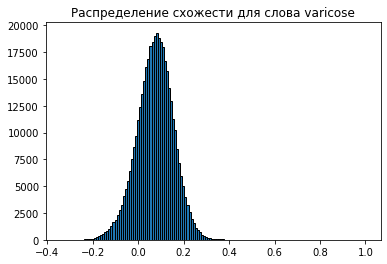

In [48]:
show_similarity_for_single_word(model_tune, 'varicose')

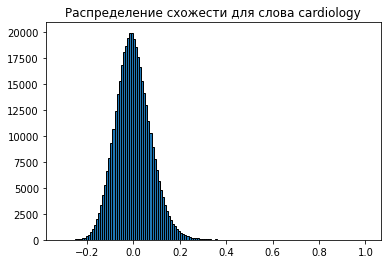

In [49]:
show_similarity_for_single_word(model_tune, 'cardiology')

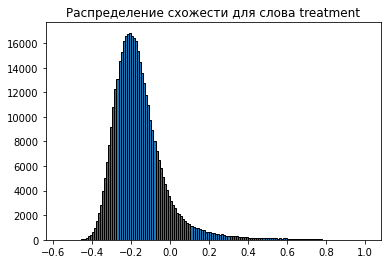

In [50]:
show_similarity_for_single_word(model_tune, 'treatment')